In [0]:
!pip install deepsurv

    100% |████████████████████████████████| 133kB 10.6MB/s 
    100% |████████████████████████████████| 266kB 25.6MB/s 
    100% |████████████████████████████████| 112kB 29.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/f9/3d/e4/0caa90decee5e102fc1ce763fa98d0021b05aec26a6a4fa552
  Stored in directory: /root/.cache/pip/wheels/a5/8e/31/b4cae7e5507f8582e77d7f5cf2815be8820ccacfa0519ca60c
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
Successfully built deepsurv lasagne bottleneck


In [0]:
import numpy as np
import pandas as pd
import lasagne
import theano
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import deepsurv

In [0]:
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

     \ 23.4MB 80.7MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-L_qRDC/wheels/33/73/96/0ed263c62a86e2485ea634e0d3ae8169d50fd66e3b252541db
Successfully built Theano
  Found existing installation: Theano 1.0.4+unknown
    Uninstalling Theano-1.0.4+unknown:
      Successfully uninstalled Theano-1.0.4+unknown


     - 1.2MB 123.8MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-tdt5Q0/wheels/ca/4a/00/87f1777b229481fe76562df7c0cfb993bc88ed0cc37e3f0ed4
Successfully built Lasagne
  Found existing installation: Lasagne 0.1
    Uninstalling Lasagne-0.1:
      Successfully uninstalled Lasagne-0.1


In [0]:
!pip install tensorboard_logger
import logging
import tensorboard_logger 
from collections import defaultdict
import sys
import math

class DeepSurvLogger():
    def __init__(self, name):
        self.logger         = logging.getLogger(name)
        self.history = {}

    def logMessage(self,message):
        self.logger.info(message)

    def print_progress_bar(self, step, max_steps, loss = None, ci = None, bar_length = 25, char = '*'):
        progress_length = int(bar_length * step / max_steps)
        progress_bar = [char] * (progress_length) + [' '] * (bar_length - progress_length)
        space_padding = int(math.log10(max_steps))
        if step > 0:
            space_padding -= int(math.log10(step))
        space_padding = ''.join([' '] * space_padding)
        message = "Training step %d/%d %s|" % (step, max_steps, space_padding) + ''.join(progress_bar) + "|"
        if loss:
            message += " - loss: %.4f" % loss
        if ci:
            message += " - ci: %.4f" % ci

        self.logger.info(message)

    def logValue(self, key, value, step):
        pass

    def shutdown(self):
        logging.shutdown()

class TensorboardLogger(DeepSurvLogger):
    def __init__(self, name, logdir, max_steps = None, update_freq = 10):
        self.max_steps = max_steps

        self.logger         = logging.getLogger(name)
        self.logger.setLevel(logging.DEBUG)
        ch = logging.StreamHandler(sys.stdout)
        format = logging.Formatter("%(asctime)s - %(message)s")
        ch.setFormatter(format)
        self.logger.addHandler(ch)

        self.update_freq    = update_freq

        self.tb_logger = tensorboard_logger.Logger(logdir)

        self.history = defaultdict(list)

    def logValue(self, key, value, step):
        self.tb_logger.log_value(key, value, step)
        self.history[key].append((step, value))

In [0]:
import h5py
import scipy.stats as st
from collections import defaultdict
import numpy as np
import pandas as pd
import copy

import lasagne

def load_datasets(dataset_file):
    datasets = defaultdict(dict)

    with h5py.File(dataset_file, 'r') as fp:
        for ds in fp:
            for array in fp[ds]:
                datasets[ds][array] = fp[ds][array][:]

    return datasets

def format_dataset_to_df(dataset, duration_col, event_col, trt_idx = None):
    xdf = pd.DataFrame(dataset['x'])
    if trt_idx is not None:
        xdf = xdf.rename(columns={trt_idx : 'treat'})

    dt = pd.DataFrame(dataset['t'], columns=[duration_col])
    censor = pd.DataFrame(dataset['e'], columns=[event_col])
    cdf = pd.concat([xdf, dt, censor], axis=1)
    return cdf

def standardize_dataset(dataset, offset, scale):
    norm_ds = copy.deepcopy(dataset)
    norm_ds['x'] = (norm_ds['x'] - offset) / scale
    return norm_ds

def bootstrap_metric(metric_fxn, dataset, N=100):
    def sample_dataset(dataset, sample_idx):
        sampled_dataset = {}
        for (key,value) in dataset.items():
            sampled_dataset[key] = value[sample_idx]
        return sampled_dataset

    metrics = []
    size = len(dataset['x'])

    for _ in range(N):
        resample_idx = np.random.choice(size, size=size, replace = True)
    
        metric = metric_fxn(**sample_dataset(dataset, resample_idx))
        metrics.append(metric)
    
    # Find mean and 95% confidence interval
    mean = np.mean(metrics)
    conf_interval = st.t.interval(0.95, len(metrics)-1, loc=mean, scale=st.sem(metrics))
    return {
        'mean': mean,
        'confidence_interval': conf_interval
    }

def get_optimizer_from_str(update_fn):
    if update_fn == 'sgd':
        return lasagne.updates.sgd
    elif update_fn == 'adam':
        return lasagne.updates.adam
    elif update_fn == 'rmsprop':
        return lasagne.updates.rmsprop

    return None

def calculate_recs_and_antirecs(rec_trt, true_trt, dataset, print_metrics=True):
    if isinstance(true_trt, int):
        true_trt = dataset['x'][:,true_trt]

    # trt_values = zip([0,1],np.sort(np.unique(true_trt)))
    trt_values = enumerate(np.sort(np.unique(true_trt)))
    equal_trt = [np.logical_and(rec_trt == rec_value, true_trt == true_value) for (rec_value, true_value) in trt_values]
    rec_idx = np.logical_or(*equal_trt)
    # original Logic
    # rec_idx = np.logical_or(np.logical_and(rec_trt == 1,true_trt == 1),
    #               np.logical_and(rec_trt == 0,true_trt == 0))

    rec_t = dataset['t'][rec_idx]
    antirec_t = dataset['t'][~rec_idx]
    rec_e = dataset['e'][rec_idx]
    antirec_e = dataset['e'][~rec_idx]

    if print_metrics:
        print("Printing treatment recommendation metrics")
        metrics = {
            'rec_median' : np.median(rec_t),
            'antirec_median' : np.median(antirec_t)
        }
        print("Recommendation metrics:", metrics)

    return {
        'rec_t' : rec_t, 
        'rec_e' : rec_e, 
        'antirec_t' : antirec_t, 
        'antirec_e' : antirec_e
    }
    

In [0]:
!pip install lifelines
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pylab

import numpy as np

import os

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

def extract_value_list(arr):
    return list(np.array(arr)[:,1])

def plot_log(log):
    """
    Plots the training and validation curves for a network's loss function
    and calculated concordance index.
    Parameters:
        log: a dictionary with a list of values for any of the following keys:
            'train': training loss
            'valid': validation loss
            'train_ci': training concordance index
            VALID_CI: validation concordance index
    """
    TRAIN_LOSS = 'loss'
    TRAIN_CI = 'c-index'
    VALID_LOSS = 'valid_loss'
    VALID_CI = 'valid_c-index'

    num_epochs = len(log[TRAIN_LOSS])

    # Plots Negative Log Likelihood vs. Epoch
    fig, ax1 = plt.subplots()
    # plt.figure()
    handles = []
    if TRAIN_LOSS in log:
        epochs = range(num_epochs)
        values = extract_value_list(log[TRAIN_LOSS])
        train, = ax1.plot(epochs, values, 'b', label = 'Training')
        ax1.tick_params('y', colors='b')
        handles.append(train)
    if VALID_LOSS in log:
        ax2 = ax1.twinx()
        epochs = np.linspace(0,num_epochs-1,num=len(log[VALID_LOSS]))
        values = extract_value_list(log[VALID_LOSS])
        valid, = ax2.plot(epochs,values, 'r', label = 'Validation')
        ax2.tick_params('y', colors='r')
        handles.append(valid)
    plt.xlabel('Epoch')
    plt.ylabel('Negative Log Likelihood')
    plt.legend(handles=handles, loc = 0)

    # Plots Concordance Index vs. Epoch
    plt.figure()
    handles = []
    if TRAIN_CI in log:
        epochs = np.linspace(0,num_epochs-1,num=len(log[TRAIN_CI]))
        train, = plt.plot(epochs, extract_value_list(log[TRAIN_CI]), label = 'Training')
        handles.append(train)
    if VALID_CI in log:
        epochs = np.linspace(0,num_epochs-1,num=len(log[VALID_CI]))
        valid, = plt.plot(epochs, extract_value_list(log[VALID_CI]), label = 'Validation')
        handles.append(valid)
    plt.xlabel('Epoch')
    plt.ylabel('Concordance Index')
    plt.legend(handles = handles, loc = 4)

def plot_risk_model(x_0, x_1, hr, figsize=(4,3), clim = (-3,3), cmap = 'jet'):
    fig, ax = plt.subplots(figsize=figsize)
    plt.xlim(-1, 1)
    plt.xlabel('$x_0$', fontsize='large')
    plt.xticks(np.arange(-1, 1.5, .5))

    plt.ylim(-1, 1)
    plt.ylabel('$x_1$', fontsize='large')
    plt.yticks(np.arange(-1, 1.5, .5))
    
    im = plt.scatter(x=x_0, y=x_1, c=hr, marker='.', cmap=cmap)
    fig.colorbar(im)
    # plt.clim(0, 1)
    plt.clim(*clim)
    plt.tight_layout()
    return (fig, ax, im)

def save_fig(fig, fp):
    # TODO fit the pdf saving cutting off the x and y axis labels
    pp_true = PdfPages(fp)
    pp_true.savefig(fig, dpi=600)
    pp_true.close()

def plot_experiment_scatters(risk_fxn, dataset, norm_vals = None, output_file=None, 
    figsize = (4,3), clim=(-3,3), cmap = 'jet', plot_error=False, trt_idx = None):
    
    def norm_hr(hr):
        # return hr
        return hr - hr.mean();
        # return (hr - hr.min()) / (hr.max() - hr.min())

    x_0 = dataset['x'][:, 0]
    x_1 = dataset['x'][:, 1]

    # Plot model predictions
    x = dataset['x']
    if norm_vals:
        x = (x - norm_vals['mean']) / norm_vals['std']

    (head, tail) = os.path.split(output_file)

    if not trt_idx is None:
        trt_values = np.unique(x[:,trt_idx])
        for (idx,trt_value) in enumerate(trt_values):
            x_trt = np.copy(x)
            x_trt[:,trt_idx] = trt_value
            hr_trt = risk_fxn(x_trt)
            hr_trt = norm_hr(hr_trt)
            fig_trt, _, _ = plot_risk_model(x_0, x_1, hr_trt, figsize, clim, cmap)

            if output_file:
                save_fig(fig_trt, os.path.join(head, "treatment_%d_" % idx + tail))
    else:
        hr_pred = risk_fxn(x)
        hr_pred = norm_hr(hr_pred)
        fig_pred, _, _ = plot_risk_model(x_0, x_1, hr_pred, figsize, clim, cmap)

        if output_file:
            save_fig(fig_pred, os.path.join(head, "pred_" + tail))

    if 'hr' in dataset:
        hr_true = dataset['hr']
        hr_true = norm_hr(hr_true)
        fig_true, _, _ = plot_risk_model(x_0, x_1, hr_true, figsize, clim, cmap)

        if output_file:
            save_fig(fig_true, os.path.join(head, "true_" + tail))

        if plot_error:
            hr_error = np.abs(hr_true - hr_pred)
            fig_error, _, _ = plot_risk_model(x_0, x_1, hr_error, figsize, clim=(0,20), cmap = cmap)

            if output_file:
                save_fig(fig_error, os.path.join(head, "error_" + tail))

def plot_survival_curves(rec_t, rec_e, antirec_t, antirec_e, experiment_name = '', output_file = None):
    # Set-up plots
    plt.figure(figsize=(12,3))
    ax = plt.subplot(111)

    # Fit survival curves
    kmf = KaplanMeierFitter()
    kmf.fit(rec_t, event_observed=rec_e, label=' '.join([experiment_name, "Recommendation"]))   
    kmf.plot(ax=ax,linestyle="-")
    kmf.fit(antirec_t, event_observed=antirec_e, label=' '.join([experiment_name, "Anti-Recommendation"]))
    kmf.plot(ax=ax,linestyle="--")
    
    # Format graph
    plt.ylim(0,1);
    ax.set_xlabel('Timeline (months)',fontsize='large')
    ax.set_ylabel('Percentage of Population Alive',fontsize='large')
    
    # Calculate p-value
    results = logrank_test(rec_t, antirec_t, rec_e, antirec_e, alpha=.95)
    results.print_summary()

    # Location the label at the 1st out of 9 tick marks
    xloc = max(np.max(rec_t),np.max(antirec_t)) / 9
    if results.p_value < 1e-5:
        ax.text(xloc,.2,'$p < 1\mathrm{e}{-5}$',fontsize=20)
    else:
        ax.text(xloc,.2,'$p=%f$' % results.p_value,fontsize=20)
    plt.legend(loc='best',prop={'size':15})


    if output_file:
        plt.tight_layout()
        pylab.savefig(output_file)

In [0]:
from __future__ import print_function, absolute_import

import lasagne
import numpy
import time
import json
import h5py

import theano
import theano.tensor as T

from lifelines.utils import concordance_index

#from .deepsurv_logger import DeepSurvLogger

from lasagne.regularization import regularize_layer_params, l1, l2
from lasagne.nonlinearities import rectify,selu

class DeepSurv:
    def __init__(self, n_in,
    learning_rate, hidden_layers_sizes = None,
    lr_decay = 0.0, momentum = 0.9,
    L2_reg = 0.0, L1_reg = 0.0,
    activation = "rectify",
    dropout = None,
    batch_norm = False,
    standardize = False,
    ):
        """
        This class implements and trains a DeepSurv model.
        Parameters:
            n_in: number of input nodes.
            learning_rate: learning rate for training.
            lr_decay: coefficient for Power learning rate decay.
            L2_reg: coefficient for L2 weight decay regularization. Used to help
                prevent the model from overfitting.
            L1_reg: coefficient for L1 weight decay regularization
            momentum: coefficient for momentum. Can be 0 or None to disable.
            hidden_layer_sizes: a list of integers to determine the size of
                each hidden layer.
            activation: a lasagne activation class.
                Default: lasagne.nonlinearities.rectify
            batch_norm: True or False. Include batch normalization layers.
            dropout: if not None or 0, the percentage of dropout to include
                after each hidden layer. Default: None
            standardize: True or False. Include standardization layer after
                input layer.
        """

        self.X = T.fmatrix('x')  # patients covariates
        self.E = T.ivector('e') # the observations vector

        # Default Standardization Values: mean = 0, std = 1
        self.offset = numpy.zeros(shape = n_in, dtype=numpy.float32)
        self.scale = numpy.ones(shape = n_in, dtype=numpy.float32)

        # self.offset = theano.shared(numpy.zeros(shape = n_in, dtype=numpy.float32))
        # self.scale = theano.shared(numpy.ones(shape = n_in, dtype=numpy.float32))

        network = lasagne.layers.InputLayer(shape=(None,n_in),
            input_var = self.X)

        # if standardize:
        #     network = lasagne.layers.standardize(network,self.offset,
        #                                         self.scale,
        #                                         shared_axes = 0)
        self.standardize = standardize

        if activation == 'rectify':
            activation_fn = rectify
        elif activation == 'selu':
            activation_fn = selu
        else:
            raise IllegalArgumentException("Unknown activation function: %s" % activation)

        # Construct Neural Network
        for n_layer in (hidden_layers_sizes or []):
            if activation_fn == lasagne.nonlinearities.rectify:
                W_init = lasagne.init.GlorotUniform()
            else:
                # TODO: implement other initializations
                W_init = lasagne.init.GlorotUniform()

            network = lasagne.layers.DenseLayer(
                network, num_units = n_layer,
                nonlinearity = activation_fn,
                W = W_init
            )

            if batch_norm:
                network = lasagne.layers.batch_norm(network)

            if not dropout is None:
                network = lasagne.layers.DropoutLayer(network, p = dropout)

        # Combine Linear to output Log Hazard Ratio - same as Faraggi
        network = lasagne.layers.DenseLayer(
            network, num_units = 1,
            nonlinearity = lasagne.nonlinearities.linear,
            W = lasagne.init.GlorotUniform()
        )

        self.network = network
        self.params = lasagne.layers.get_all_params(self.network,
                                                    trainable = True)
        self.hidden_layers = lasagne.layers.get_all_layers(self.network)[1:]

        # Relevant Functions
        self.partial_hazard = T.exp(self.risk(deterministic = True)) # e^h(x)

        # Store and set needed Hyper-parameters:
        self.hyperparams = {
            'n_in': n_in,
            'learning_rate': learning_rate,
            'hidden_layers_sizes': hidden_layers_sizes,
            'lr_decay': lr_decay,
            'momentum': momentum,
            'L2_reg': L2_reg,
            'L1_reg': L1_reg,
            'activation': activation,
            'dropout': dropout,
            'batch_norm': batch_norm,
            'standardize': standardize
        }

        self.n_in = n_in
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.L2_reg = L2_reg
        self.L1_reg = L1_reg
        self.momentum = momentum
        self.restored_update_params = None

    def _negative_log_likelihood(self, E, deterministic = False):
        """Return the negative average log-likelihood of the prediction
            of this model under a given target distribution.
        .. math::
            \frac{1}{N_D} \sum_{i \in D}[F(x_i,\theta) - log(\sum_{j \in R_i} e^F(x_j,\theta))]
                - \lambda P(\theta)
        where:
            D is the set of observed events
            N_D is the number of observed events
            R_i is the set of examples that are still alive at time of death t_j
            F(x,\theta) = log hazard rate
        Note: We assume that there are no tied event times
        Parameters:
            E (n,): TensorVector that corresponds to a vector that gives the censor
                variable for each example
            deterministic: True or False. Determines if the output of the network
                is calculated determinsitically.
        Returns:
            neg_likelihood: Theano expression that computes negative
                partial Cox likelihood
        """
        risk = self.risk(deterministic)
        hazard_ratio = T.exp(risk)
        log_risk = T.log(T.extra_ops.cumsum(hazard_ratio))
        uncensored_likelihood = risk.T - log_risk
        censored_likelihood = uncensored_likelihood * E
        num_observed_events = T.sum(E)
        neg_likelihood = -T.sum(censored_likelihood) / num_observed_events
        return neg_likelihood

    def _get_loss_updates(self,
    L1_reg = 0.0, L2_reg = 0.001,
    update_fn = lasagne.updates.nesterov_momentum,
    max_norm = None, deterministic = False,
    momentum = 0.9,
    **kwargs):
        """
        Returns Theano expressions for the network's loss function and parameter
            updates.
        Parameters:
            L1_reg: float for L1 weight regularization coefficient.
            L2_reg: float for L2 weight regularization coefficient.
            max_norm: If not None, constraints the norm of gradients to be less
                than max_norm.
            deterministic: True or False. Determines if the output of the network
                is calculated determinsitically.
            update_fn: lasagne update function.
                Default: Stochastic Gradient Descent with Nesterov momentum
            **kwargs: additional parameters to provide to update_fn.
                For example: momentum
        Returns:
            loss: Theano expression for a penalized negative log likelihood.
            updates: Theano expression to update the parameters using update_fn.
        """

        loss = (
            self._negative_log_likelihood(self.E, deterministic)
            + regularize_layer_params(self.network,l1) * L1_reg
            + regularize_layer_params(self.network, l2) * L2_reg
        )

        if max_norm:
            grads = T.grad(loss,self.params)
            scaled_grads = lasagne.updates.total_norm_constraint(grads, max_norm)
            updates = update_fn(
                scaled_grads, self.params, **kwargs
            )
        else:
            updates = update_fn(
                loss, self.params, **kwargs
            )

        if momentum:
            updates = lasagne.updates.apply_nesterov_momentum(updates, 
                self.params, self.learning_rate, momentum=momentum)

        # If the model was loaded from file, reload params
        if self.restored_update_params:
            for p, value in zip(updates.keys(), self.restored_update_params):
                p.set_value(value)
            self.restored_update_params = None

        # Store last update function to be later saved
        self.updates = updates

        return loss, updates

    def _get_train_valid_fn(self,
    L1_reg, L2_reg, learning_rate,
    **kwargs):
        """
        Builds the loss and update Theano expressions into callable Theano functions.
        Parameters:
            L1_reg: coefficient for L1 weight decay regularization
            L2_reg: coefficient for L2 weight decay regularization. Used to help
                prevent the model from overfitting.
            learning_rate: learning rate coefficient.
            **kwargs: additional parameters to provide to _get_loss_updates.
        Returns:
            train_fn: Theano function that takes a (n, d) array and (n,) vector
                and computes the loss function and updates the network parameters.
                Calculated non-deterministically.
            valid_fn: Theano function that takes a (n, d) array and (n,) vector
                and computes the loss function without updating the network parameters.
                Calcualted deterministically.
        """

        loss, updates = self._get_loss_updates(
            L1_reg, L2_reg, deterministic = False,
            learning_rate=learning_rate, **kwargs
        )
        train_fn = theano.function(
            inputs = [self.X, self.E],
            outputs = loss,
            updates = updates,
            name = 'train'
        )

        valid_loss, _ = self._get_loss_updates(
            L1_reg, L2_reg, deterministic = True,
            learning_rate=learning_rate, **kwargs
        )

        valid_fn = theano.function(
            inputs = [self.X, self.E],
            outputs = valid_loss,
            name = 'valid'
        )
        return train_fn, valid_fn

    def get_concordance_index(self, x, t, e, **kwargs):
        """
        Taken from the lifelines.utils package. Docstring is provided below.
        Parameters:
            x: (n, d) numpy array of observations.
            t: (n) numpy array representing observed time events.
            e: (n) numpy array representing time indicators.
        Returns:
            concordance_index: calcualted using lifelines.utils.concordance_index
        lifelines.utils.concordance index docstring:
        Calculates the concordance index (C-index) between two series
        of event times. The first is the real survival times from
        the experimental data, and the other is the predicted survival
        times from a model of some kind.
        The concordance index is a value between 0 and 1 where,
        0.5 is the expected result from random predictions,
        1.0 is perfect concordance and,
        0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)
        Score is usually 0.6-0.7 for survival models.
        See:
        Harrell FE, Lee KL, Mark DB. Multivariable prognostic models: issues in
        developing models, evaluating assumptions and adequacy, and measuring and
        reducing errors. Statistics in Medicine 1996;15(4):361-87.
        """
        compute_hazards = theano.function(
            inputs = [self.X],
            outputs = -self.partial_hazard
        )
        partial_hazards = compute_hazards(x)

        return concordance_index(t,
            partial_hazards,
            e)

    def _standardize_x(self, x):
        return (x - self.offset) / self.scale

    # @TODO: implement for varios instances of datasets
    def prepare_data(self,dataset):
        if isinstance(dataset, dict):
            x, e, t = dataset['x'], dataset['e'], dataset['t']

        if self.standardize:
            x = self._standardize_x(x)

        # Sort Training Data for Accurate Likelihood
        sort_idx = numpy.argsort(t)[::-1]
        x = x[sort_idx]
        e = e[sort_idx]
        t = t[sort_idx]

        return (x, e, t)

    def train(self,
    train_data, valid_data= None,
    n_epochs = 500,
    validation_frequency = 250,
    patience = 2000, improvement_threshold = 0.99999, patience_increase = 2,
    logger = None,
    update_fn = lasagne.updates.nesterov_momentum,
    verbose = True,
    **kwargs):
        """
        Trains a DeepSurv network on the provided training data and evalutes
            it on the validation data.
        Parameters:
            train_data: dictionary with the following keys:
                'x' : (n,d) array of observations (dtype = float32).
                't' : (n) array of observed time events (dtype = float32).
                'e' : (n) array of observed time indicators (dtype = int32).
            valid_data: optional. A dictionary with the following keys:
                'x' : (n,d) array of observations.
                't' : (n) array of observed time events.
                'e' : (n) array of observed time indicators.
            standardize: True or False. Set the offset and scale of
                standardization layey to the mean and standard deviation of the
                training data.
            n_epochs: integer for the maximum number of epochs the network will
                train for.
            validation_frequency: how often the network computes the validation
                metrics. Decreasing validation_frequency increases training speed.
            patience: minimum number of epochs to train for. Once patience is
                reached, looks at validation improvement to increase patience or
                early stop.
            improvement_threshold: percentage of improvement needed to increase
                patience.
            patience_increase: multiplier to patience if threshold is reached.
            logger: None or DeepSurvLogger.
            update_fn: lasagne update function for training.
                Default: lasagne.updates.nesterov_momentum
            **kwargs: additional parameters to provide _get_train_valid_fn.
                Parameters used to provide configurations to update_fn.
        Returns:
            metrics: a dictionary of training metrics that include:
                'train': a list of loss values for each training epoch
                'train_ci': a list of C-indices for each training epoch
                'best_params': a list of numpy arrays containing the parameters
                    when the network had the best validation loss
                'best_params_idx': the epoch at which best_params was found
            If valid_data is provided, the metrics also contain:
                'valid': a list of validation loss values for each validation frequency
                'valid_ci': a list of validation C-indiices for each validation frequency
                'best_validation_loss': the best validation loss found during training
                'best_valid_ci': the max validation C-index found during training
        """
        if logger is None:
            logger = DeepSurvLogger('DeepSurv')

        # Set Standardization layer offset and scale to training data mean and std
        if self.standardize:
            self.offset = train_data['x'].mean(axis = 0)
            self.scale = train_data['x'].std(axis = 0)

        x_train, e_train, t_train = self.prepare_data(train_data)

        if valid_data:
            x_valid, e_valid, t_valid = self.prepare_data(valid_data)

        # Initialize Metrics
        best_validation_loss = numpy.inf
        best_params = None
        best_params_idx = -1

        # Initialize Training Parameters
        lr = theano.shared(numpy.array(self.learning_rate,
                                    dtype = numpy.float32))
        momentum = numpy.array(0, dtype= numpy.float32)

        train_fn, valid_fn = self._get_train_valid_fn(
            L1_reg=self.L1_reg, L2_reg=self.L2_reg,
            learning_rate=lr,
            momentum = momentum,
            update_fn = update_fn, **kwargs
        )

        start = time.time()
        for epoch in range(n_epochs):
            # Power-Learning Rate Decay
            lr = self.learning_rate / (1 + epoch * self.lr_decay)
            logger.logValue('lr', lr, epoch)

            if self.momentum and epoch >= 10:
                momentum = self.momentum

            loss = train_fn(x_train, e_train)

            logger.logValue('loss', loss, epoch)
            # train_loss.append(loss)

            ci_train = self.get_concordance_index(
                x_train,
                t_train,
                e_train,
            )
            logger.logValue('c-index',ci_train, epoch)
            # train_ci.append(ci_train)

            if valid_data and (epoch % validation_frequency == 0):
                validation_loss = valid_fn(x_valid, e_valid)
                logger.logValue('valid_loss',validation_loss, epoch)

                ci_valid = self.get_concordance_index(
                    x_valid,
                    t_valid,
                    e_valid
                )
                logger.logValue('valid_c-index', ci_valid, epoch)

                if validation_loss < best_validation_loss:
                    # improve patience if loss improves enough
                    if validation_loss < best_validation_loss * improvement_threshold:
                        patience = max(patience, epoch * patience_increase)

                    best_params = [param.copy().eval() for param in self.params]
                    best_params_idx = epoch
                    best_validation_loss = validation_loss

            if verbose and (epoch % validation_frequency == 0):
                logger.print_progress_bar(epoch, n_epochs, loss, ci_train)

            if patience <= epoch:
                break

        if verbose:
            logger.logMessage('Finished Training with %d iterations in %0.2fs' % (
                epoch + 1, time.time() - start
            ))
        logger.shutdown()

        # Return Logger.getMetrics()
        # metrics = {
        #     'train': train_loss,
        #     'best_params': best_params,
        #     'best_params_idx' : best_params_idx,
        #     'train_ci' : train_ci
        # }
        # if valid_data:
        #     metrics.update({
        #         'valid' : valid_loss,
        #         'valid_ci': valid_ci,
        #         'best_valid_ci': max(valid_ci),
        #         'best_validation_loss':best_validation_loss
        #     })
        logger.history['best_valid_loss'] = best_validation_loss
        logger.history['best_params'] = best_params
        logger.history['best_params_idx'] = best_params_idx

        return logger.history

    def to_json(self):
        return json.dumps(self.hyperparams)

    def save_model(self, filename, weights_file = None):
        with open(filename, 'w') as fp:
            fp.write(self.to_json())

        if weights_file:
            self.save_weights(weights_file)

    def save_weights(self,filename):
        def save_list_by_idx(group, lst):
            for (idx, param) in enumerate(lst):
                group.create_dataset(str(idx), data=param)

        weights_out = lasagne.layers.get_all_param_values(self.network, trainable=False)
        if self.updates:
            updates_out = [p.get_value() for p in self.updates.keys()]
        else:
            raise Exception("Model has not been trained: no params to save!")

        # Store all of the parameters in an hd5f file
        # We store the parameter under the index in the list
        # so that when we read it later, we can construct the list of
        # parameters in the same order they were saved
        with h5py.File(filename, 'w') as f_out:
            weights_grp = f_out.create_group('weights')
            save_list_by_idx(weights_grp, weights_out)

            updates_grp = f_out.create_group('updates')
            save_list_by_idx(updates_grp, updates_out)

    def load_weights(self, filename):
        def load_all_keys(fp):
            results = []
            for key in fp:
                dataset = fp[key][:]
                results.append((int(key), dataset))
            return results

        def sort_params_by_idx(params):
            return [param for (idx, param) in sorted(params, 
            key=lambda param: param[0])]

        # Load all of the parameters
        with h5py.File(filename, 'r') as f_in:
            weights_in = load_all_keys(f_in['weights'])
            updates_in = load_all_keys(f_in['updates'])

        # Sort them according to the idx to ensure they are set correctly
        sorted_weights_in = sort_params_by_idx(weights_in)
        lasagne.layers.set_all_param_values(self.network, sorted_weights_in, 
            trainable=False)

        sorted_updates_in = sort_params_by_idx(updates_in)
        self.restored_update_params = sorted_updates_in

    def risk(self,deterministic = False):
        """
        Returns a theano expression for the output of network which is an
            observation's predicted risk.
        Parameters:
            deterministic: True or False. Determines if the output of the network
                is calculated determinsitically.
        Returns:
            risk: a theano expression representing a predicted risk h(x)
        """
        return lasagne.layers.get_output(self.network,
                                        deterministic = deterministic)

    def predict_risk(self, x):
        """
        Calculates the predicted risk for an array of observations.
        Parameters:
            x: (n,d) numpy array of observations.
        Returns:
            risks: (n) array of predicted risks
        """
        risk_fxn = theano.function(
            inputs = [self.X],
            outputs = self.risk(deterministic= True),
            name = 'predicted risk'
        )
        return risk_fxn(x)

    def recommend_treatment(self, x, trt_i, trt_j, trt_idx = -1):
        """
        Computes recommendation function rec_ij(x) for two treatments i and j.
            rec_ij(x) is the log of the hazards ratio of x in treatment i vs.
            treatment j.
        .. math::
            rec_{ij}(x) = log(e^h_i(x) / e^h_j(x)) = h_i(x) - h_j(x)
        Parameters:
            x: (n, d) numpy array of observations
            trt_i: treatment i value
            trt_j: treatment j value
            trt_idx: the index of x representing the treatment group column
        Returns:
            rec_ij: recommendation
        """
        # Copy x to prevent overwritting data
        x_trt = numpy.copy(x)

        # Calculate risk of observations treatment i
        x_trt[:,trt_idx] = trt_i
        h_i = self.predict_risk(x_trt)
        # Risk of observations in treatment j
        x_trt[:,trt_idx] = trt_j;
        h_j = self.predict_risk(x_trt)

        rec_ij = h_i - h_j
        return rec_ij

    def plot_risk_surface(self, data, i = 0, j = 1,
        figsize = (6,4), x_lims = None, y_lims = None, c_lims = None):
        """
        Plots the predicted risk surface of the network with respect to two
        observed covarites i and j.
        Parameters:
            data: (n,d) numpy array of observations of which to predict risk.
            i: index of data to plot as axis 1
            j: index of data to plot as axis 2
            figsize: size of figure for matplotlib
            x_lims: Optional. If provided, override default x_lims (min(x_i), max(x_i))
            y_lims: Optional. If provided, override default y_lims (min(x_j), max(x_j))
            c_lims: Optional. If provided, override default color limits.
        Returns:
            fig: matplotlib figure object.
        """
        fig = plt.figure(figsize=figsize)
        X = data[:,i]
        Y = data[:,j]
        Z = self.predict_risk(data)

        if not x_lims is None:
            x_lims = [np.round(np.min(X)), np.round(np.max(X))]
        if not y_lims is None:
            y_lims = [np.round(np.min(Y)), np.round(np.max(Y))]
        if not c_lims is None:
            c_lims = [np.round(np.min(Z)), np.round(np.max(Z))]

        ax = plt.scatter(X,Y, c = Z, edgecolors = 'none', marker = '.')
        ax.set_clim(*c_lims)
        plt.colorbar()
        plt.xlim(*x_lims)
        plt.ylim(*y_lims)
        plt.xlabel('$x_{%d}$' % i, fontsize=18)
        plt.ylabel('$x_{%d}$' % j, fontsize=18)

        return fig

def load_model_from_json(model_fp, weights_fp = None):
    with open(model_fp, 'r') as fp:
        json_model = fp.read()
    print('Loading json model:',json_model)
    hyperparams = json.loads(json_model)

    model = DeepSurv(**hyperparams)

    if weights_fp:
        model.load_weights(weights_fp)

    return model

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1TWOQRK0esxxu5l97JhGwfrGCzjHTcBNl' # The shareable link

In [0]:
fluff, id = link.split('=')
print (id)

1TWOQRK0esxxu5l97JhGwfrGCzjHTcBNl


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('va_train.csv')  
df3_train = pd.read_csv('va_train.csv')

In [0]:
def dataframe_to_deepsurv_ds(df, event_col = 'status', time_col = 'stime'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(df3_train, event_col = 'status', time_col= 'stime')
valid_data = dataframe_to_deepsurv_ds(df3_valid, event_col = 'status', time_col= 'stime')

In [0]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
}

In [0]:
model = deepsurv.DeepSurv(**hyperparams)

In [0]:
logger= None 
update_fn=lasagne.updates.nesterov_momentum 
n_epochs = 2000

metrics = model.train(train_data, valid_data, n_epochs=n_epochs,update_fn=update_fn)

[INFO] Training CoxMLP
Finished Training with 2000 iterations in 372.24s


In [0]:
model.get_concordance_index(**train_data)

0.7325826882477129

In [199]:
model.get_concordance_index(**valid_data)

0.7134670487106017

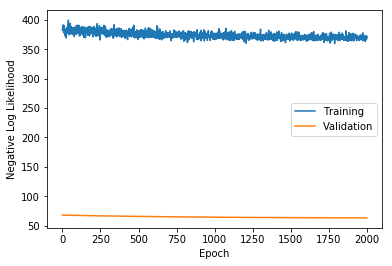

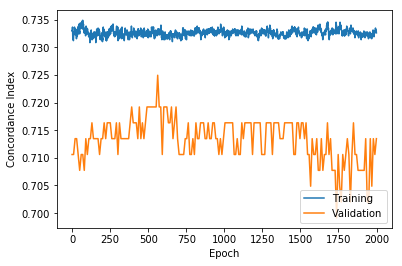

In [198]:
deepsurv.plot_log(metrics)

In [0]:
rec_train = model.recommend_treatment(train_data['x'], train_data['t'], 2, 1)

In [0]:
rec_valid = model.recommend_treatment(valid_data['x'], valid_data['t'], 2, 1)

In [0]:
data = pd.DataFrame(rec_train)

In [0]:
data_valid = pd.DataFrame(rec_valid)

In [0]:
data_valid.columns = ['recij_valid']

In [0]:
data.columns = ['recij']

In [197]:
data

,recij
0,-0.869285
1,6.892474
2,2.344195
3,0.420172
4,0.501167
5,-0.189242
6,-0.870105
7,0.119706
8,4.271060
9,-0.150997


In [182]:
data_valid

,recij_valid
0,-0.807803
1,-1.162650
2,-0.266880
3,-1.144302
4,-0.911277
5,-0.158394
6,-0.936148
7,-1.079177
8,-0.136808
9,0.518102


In [0]:
data.loc[data['recij'] >= 0,'recij'] = 1
data.loc[data['recij'] < 0,'recij'] = 2

In [0]:
data_valid.loc[data_valid['recij_valid'] >= 0,'recij_valid'] = 1
data_valid.loc[data_valid['recij_valid'] < 0,'recij_valid'] = 2

In [193]:
data

,recij
0,2.0
1,1.0
2,1.0
3,1.0
4,1.0
5,2.0
6,2.0
7,1.0
8,1.0
9,2.0


In [184]:
data_valid

,recij_valid
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
5,2.0
6,2.0
7,2.0
8,2.0
9,1.0
